In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import torch

### Faster RCNN

In [2]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data.datasets import register_coco_instances


class Config:
    PIXEL = 384


cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.MODEL.WEIGHTS = "./detectron_output/model_final.pth"
cfg.INPUT.MIN_SIZE_TRAIN = Config.PIXEL
cfg.INPUT.MAX_SIZE_TRAIN = Config.PIXEL
cfg.INPUT.MIN_SIZE_TEST = Config.PIXEL
cfg.INPUT.MAX_SIZE_TEST = Config.PIXEL

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 26  # Number of classes (A-Z)
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[32, 64, 128]]  # [[32, 64, 128, 256, 512]]
cfg.MODEL.FPN.OUT_CHANNELS = 128  # 256

predictor = DefaultPredictor(cfg)

test_image_path = '/home/xiang/Desktop/Data_Mining/project/data/ASLv1/processed_yolo11/images/test'
test_json_path = f'{test_image_path}/annotations.json'

register_coco_instances("asl_test", {}, test_json_path, test_image_path)
evaluator = COCOEvaluator("asl_test",
                          cfg,
                          False,
                          output_dir="./detectron_output/test/")
test_loader = build_detection_test_loader(cfg, "asl_test")

metrics = inference_on_dataset(predictor.model, test_loader, evaluator)
print(metrics)

COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
/home/xiang/han/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.904
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.631
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.555
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.598
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.598
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.598
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.5

In [3]:
# Measure inference time
start_time = time.time()  # Start timing
metrics = inference_on_dataset(predictor.model, test_loader,
                               evaluator)  # Run evaluation
end_time = time.time()  # End timing

# Calculate average inference time
total_time = end_time - start_time  # Total time for all images
num_images = len(test_loader.dataset)  # Number of images in the test set
average_time_ms = (total_time / num_images) * 1000  # Convert to ms per image

# Print results
print(f"Evaluation Metrics: {metrics}")
print(f"Average inference time per image: {average_time_ms:.2f} ms")

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.904
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.631
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.555
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.598
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.598
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.598
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.5

In [4]:
model = predictor.model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 32298096


In [5]:
faster_rcnn_train_cls_losses = [
    0.237, 0.152, 0.08, 0.07, 0.063, 0.045, 0.046, 0.031, 0.034, 0.023, 0.016,
    0.016, 0.013, 0.011, 0.011
]

faster_rcnn_val_map = [
    0.13, 0.3, 0.43, 0.497, 0.523, 0.572, 0.572, 0.588, 0.638, 0.617, 0.669,
    0.709, 0.724, 0.746, 0.751
]

### Yolo11 and RT_DETR

In [6]:
from ultralytics import RTDETR, YOLO

In [7]:
metrics_files = {
    'YOLO-n': './runs/detect/train6',
    'YOLO-l': './runs/detect/train15',
    'YOLO-x': './runs/detect/train_yolo_x',
    'RT-DETR-l': '/runs/detect/train14',
    'RT-DETR-x': '/runs/detect/train_rtdetr_x',
}

In [8]:
def get_ultralytics_model_result(model, batch=32):
    results = model.val(data='asl.yaml', split='test', imgsz=384, batch=batch)
    map_50_95 = results.box.map  # Bounding box mAP@50-95

    average_inference_time = results.speed['inference']

    return map_50_95, average_inference_time


def get_ultralytics_training_losses(result_path):
    result_csv_path = f'./{result_path}/results.csv'
    df = pd.read_csv(result_csv_path, index_col=False)
    train_cls_loss = df['train/cls_loss'].to_list()
    return train_cls_loss

In [9]:
yolo11n_model = YOLO(f'./{metrics_files["YOLO-n"]}/weights/best.pt')
yolo11n_train_cls_losses = get_ultralytics_training_losses(
    metrics_files['YOLO-n'])
test_map, avg_inference_time = get_ultralytics_model_result(yolo11n_model)
print(f'Yolo11_n inference time is {avg_inference_time}')
print(f'Yolo11_n test map is {test_map}')
print(f'Yolo11_n training cls loss is {yolo11n_train_cls_losses}')

Ultralytics 8.3.20 🚀 Python-3.11.4 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7940MiB)
YOLO11n summary (fused): 238 layers, 2,587,222 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /home/xiang/Desktop/Data_Mining/project/data/ASLv1/processed_yolo11/labels/test.cache... 72 images, 0 backgrounds, 0 corrupt: 100%|██████████| 72/72 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


                   all         72         72      0.945      0.919      0.957      0.692
             Letter: A          1          1       0.91          1      0.995      0.895
             Letter: B          3          3      0.967          1      0.995      0.706
             Letter: C          4          4      0.963          1      0.995      0.743
             Letter: D          1          1      0.813          1      0.995      0.796
             Letter: F          2          2      0.965          1      0.995      0.474
             Letter: G          5          5      0.977          1      0.995      0.724
             Letter: H          3          3      0.965          1      0.995       0.42
             Letter: I          2          2      0.969        0.5      0.745      0.461
             Letter: J          4          4      0.858          1      0.995        0.7
             Letter: K          4          4      0.996          1      0.995      0.627
             Letter: 

In [ ]:
yolo11l_model = YOLO(f'./{metrics_files["YOLO-l"]}/weights/best.pt')
yolo11l_train_cls_losses = get_ultralytics_training_losses(
    metrics_files['YOLO-l'])
test_map, avg_inference_time = get_ultralytics_model_result(yolo11l_model)
print(f'Yolo11_l inference time is {avg_inference_time}')
print(f'Yolo11_l test map is {test_map}')
print(f'Yolo11_l training cls loss is {yolo11n_train_cls_losses}')

Ultralytics 8.3.20 🚀 Python-3.11.4 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7940MiB)
YOLO11l summary (fused): 464 layers, 25,299,358 parameters, 0 gradients, 86.7 GFLOPs


val: Scanning /home/xiang/Desktop/Data_Mining/project/data/ASLv1/processed_yolo11/labels/test.cache... 72 images, 0 backgrounds, 0 corrupt: 100%|██████████| 72/72 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


                   all         72         72      0.963        0.9      0.984      0.777
             Letter: A          1          1      0.845          1      0.995      0.995
             Letter: B          3          3      0.977          1      0.995      0.734
             Letter: C          4          4      0.967          1      0.995      0.833
             Letter: D          1          1      0.926          1      0.995      0.895
             Letter: F          2          2      0.961          1      0.995      0.705
             Letter: G          5          5      0.994          1      0.995      0.734
             Letter: H          3          3      0.967          1      0.995      0.398
             Letter: I          2          2          1      0.557      0.995      0.796
             Letter: J          4          4      0.983          1      0.995      0.753
             Letter: K          4          4      0.974          1      0.995      0.817
             Letter: 

In [ ]:
torch.cuda.empty_cache()
yolo11x_model = YOLO(f'./{metrics_files["YOLO-x"]}/weights/best.pt')
yolo11x_train_cls_losses = get_ultralytics_training_losses(
    metrics_files['YOLO-x'])
test_map, avg_inference_time = get_ultralytics_model_result(yolo11x_model)
print(f'Yolo11_x inference time is {avg_inference_time}')
print(f'Yolo11_x test map is {test_map}')
print(f'Yolo11_x training cls loss is {yolo11x_train_cls_losses}')

Ultralytics 8.3.20 🚀 Python-3.11.4 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7940MiB)
YOLO11x summary (fused): 464 layers, 56,857,054 parameters, 0 gradients, 194.6 GFLOPs


val: Scanning /home/xiang/Desktop/Data_Mining/project/data/ASLv1/processed_yolo11/labels/test.cache... 72 images, 0 backgrounds, 0 corrupt: 100%|██████████| 72/72 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


                   all         72         72      0.933      0.878      0.952      0.778
             Letter: A          1          1       0.61          1      0.995      0.895
             Letter: B          3          3      0.973          1      0.995      0.815
             Letter: C          4          4          1      0.953      0.995      0.883
             Letter: D          1          1      0.945          1      0.995      0.895
             Letter: F          2          2      0.963          1      0.995      0.796
             Letter: G          5          5      0.994          1      0.995      0.775
             Letter: H          3          3          1      0.859      0.995      0.606
             Letter: I          2          2      0.913        0.5      0.559      0.503
             Letter: J          4          4      0.984          1      0.995      0.636
             Letter: K          4          4      0.984          1      0.995      0.895
             Letter: 

In [ ]:
retrl_model = RTDETR(f'./{metrics_files["RT-DETR-l"]}/weights/best.pt')
retrl_train_cls_losses = get_ultralytics_training_losses(
    metrics_files['RT-DETR-l'])
test_map, avg_inference_time = get_ultralytics_model_result(retrl_model)
print(f'retrl inference time is {avg_inference_time}')
print(f'retrl test map is {test_map}')
print(f'retrl training cls loss is {retrl_train_cls_losses}')

Ultralytics 8.3.20 🚀 Python-3.11.4 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7940MiB)
rt-detr-l summary: 502 layers, 32,037,170 parameters, 0 gradients, 103.5 GFLOPs


val: Scanning /home/xiang/Desktop/Data_Mining/project/data/ASLv1/processed_yolo11/labels/test.cache... 72 images, 0 backgrounds, 0 corrupt: 100%|██████████| 72/72 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


                   all         72         72      0.944       0.89      0.918      0.753
             Letter: A          1          1      0.498          1      0.995      0.995
             Letter: B          3          3       0.98          1      0.995      0.863
             Letter: C          4          4      0.862          1      0.995      0.859
             Letter: D          1          1      0.963          1      0.995      0.796
             Letter: F          2          2      0.977          1      0.995      0.721
             Letter: G          5          5       0.99          1      0.995      0.837
             Letter: H          3          3      0.995          1      0.995      0.627
             Letter: I          2          2      0.962        0.5      0.495      0.446
             Letter: J          4          4      0.989          1      0.995      0.773
             Letter: K          4          4      0.983       0.75      0.745      0.621
             Letter: 

In [ ]:
retrx_model = RTDETR(f'./{metrics_files["RT-DETR-x"]}/weights/best.pt')
retrx_train_cls_losses = get_ultralytics_training_losses(
    metrics_files['RT-DETR-x'])
test_map, avg_inference_time = get_ultralytics_model_result(retrx_model)
print(f'retrl inference time is {avg_inference_time}')
print(f'retrl test map is {test_map}')
print(f'retrl training cls loss is {retrx_train_cls_losses}')

Ultralytics 8.3.20 🚀 Python-3.11.4 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7940MiB)
rt-detr-x summary: 646 layers, 65,520,866 parameters, 0 gradients, 222.6 GFLOPs


val: Scanning /home/xiang/Desktop/Data_Mining/project/data/ASLv1/processed_yolo11/labels/test.cache... 72 images, 0 backgrounds, 0 corrupt: 100%|██████████| 72/72 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


                   all         72         72      0.961      0.918      0.926      0.793
             Letter: A          1          1      0.855          1      0.995      0.995
             Letter: B          3          3      0.983          1      0.995      0.882
             Letter: C          4          4      0.991          1      0.995      0.871
             Letter: D          1          1      0.653          1      0.995      0.897
             Letter: F          2          2      0.973          1      0.995       0.83
             Letter: G          5          5      0.991          1      0.995      0.799
             Letter: H          3          3      0.998          1      0.995      0.731
             Letter: I          2          2      0.962        0.5      0.496      0.403
             Letter: J          4          4      0.987          1      0.995      0.761
             Letter: K          4          4      0.987          1      0.995      0.849
             Letter: 

In [10]:
yolo11n_val_map = [
    0.074, 0.343, 0.455, 0.49, 0.622, 0.667, 0.726, 0.702, 0.786, 0.8, 0.805,
    0.819, 0.831, 0.846, 0.856
]

yolo11l_val_map = [
    0.478, 0.575, 0.596, 0.666, 0.696, 0.715, 0.758, 0.768, 0.792, 0.817,
    0.828, 0.843, 0.855, 0.866, 0.874
]

yolo11x_val_map = [
    0.461, 0.361, 0.423, 0.59, 0.623, 0.595, 0.713, 0.596, 0.736, 0.794, 0.834,
    0.84, 0.865, 0.878, 0.89
]

detrl_val_map = [
    0.497, 0.682, 0.711, 0.755, 0.78, 0.777, 0.812, 0.836, 0.846, 0.835, 0.85,
    0.868, 0.863, 0.863, 0.873
]

detrx_val_map = [
    0.218, 0.694, 0.686, 0.782, 0.704, 0.792, 0.775, 0.83, 0.858, 0.827, 0.872,
    0.878, 0.889, 0.88, 0.887
]

In [11]:
train_cls_losses_dict = {
    'yolo11-n': get_ultralytics_training_losses(metrics_files['YOLO-n']),
    'yolo11-l': get_ultralytics_training_losses(metrics_files['YOLO-l']),
    'yolo11-x': get_ultralytics_training_losses(metrics_files['YOLO-x']),
    'rt-detr-l': get_ultralytics_training_losses(metrics_files['RT-DETR-l']),
    'rt-detr-x': get_ultralytics_training_losses(metrics_files['RT-DETR-x']),
    'faster_rcnn': faster_rcnn_train_cls_losses
}

val_val_map_dict = {
    'yolo11-n': yolo11n_val_map,
    'yolo11-l': yolo11l_val_map,
    'yolo11-x': yolo11x_val_map,
    'rt-detr-l': detrl_val_map,
    'rt-detr-x': detrx_val_map,
    'faster_rcnn': faster_rcnn_val_map
}

In [20]:
def plot_training(train_cls_losses_dict, val_val_map_dict):
    label_offset_loss = 0.001
    label_offset_map = 0.001
    threshold_loss = 0.005  # Minimum change threshold for text plotting
    threshold_map = 0.008  # Minimum change threshold for text plotting

    # Generate plots
    plt.figure(figsize=(12, 6))

    # Plot training classification loss (log scale)
    plt.subplot(1, 2, 1)
    for idx, (model, losses) in enumerate(train_cls_losses_dict.items()):
        epochs = range(1, len(losses) + 1)
        plt.plot(epochs, losses, label=model)
        # Add value at the last epoch with separation if change is significant
        if len(losses) > 1 and abs(losses[-1] - losses[-2]) >= threshold_loss:
            offset = label_offset_loss * (idx + 1
                                          )  # Dynamic offset for separation
            y_pos = losses[-1] + offset  # Calculate label position
            plt.text(epochs[-1],
                     y_pos,
                     f"{losses[-1]:.2f}",
                     fontsize=7,
                     ha='left')
        else:
            plt.text(epochs[-1],
                     losses[-1],
                     f"{losses[-1]:.2f}",
                     fontsize=7,
                     ha='left')
    plt.title('Training Classification Loss (Log Scale)')
    plt.xscale('log')  # Apply log scale to x-axis
    plt.yscale('log')  # Apply log scale to y-axis
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(False)  # Remove grid lines

    # Plot validation mAP
    plt.subplot(1, 2, 2)
    last_maps = [0]
    for idx, (model, maps) in enumerate(val_val_map_dict.items()):
        epochs = range(1, len(maps) + 1)
        plt.plot(epochs, maps, label=model)
        # Add value at the last epoch with separation if change is significant
        if len(maps) > 1 and abs(last_maps[-1] - maps[-1]) >= threshold_map:
            offset = label_offset_map * (idx + 1
                                         )  # Dynamic offset for separation
            y_pos = maps[-1] + offset
            y_pos = min(y_pos, 1.0)  # Keep label within plot bounds
            plt.text(epochs[-1],
                     y_pos,
                     f"{maps[-1]:.2f}",
                     fontsize=7,
                     ha='left')
        last_maps = maps
    plt.title('Validation mAP (IoU 50-95)')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.legend()
    plt.grid(False)  # Remove grid lines

    plt.tight_layout()
    plt.show()

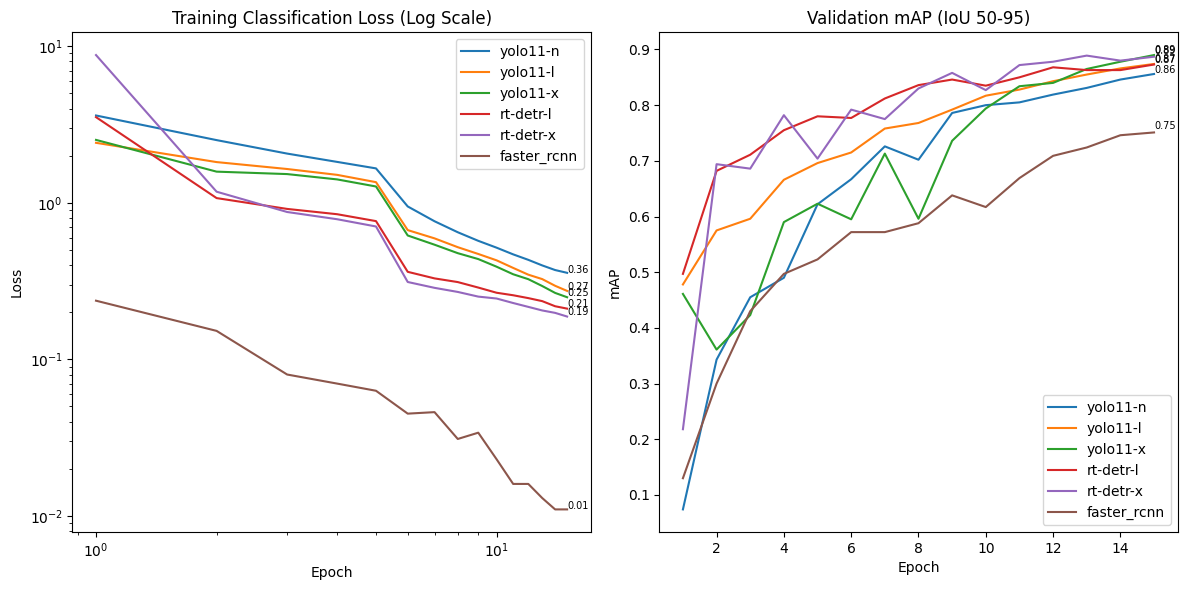

In [21]:
plot_training(train_cls_losses_dict, val_val_map_dict)